In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import joblib
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!mkdir predict

In [4]:
x_test_origin = pd.read_csv("/content/drive/MyDrive/CS 5228/input_test_before_EncNorm.csv")
x_train = pd.read_csv("/content/drive/MyDrive/CS 5228/input_train_features_before_EncNorm.csv")
y_train = pd.read_csv("/content/drive/MyDrive/CS 5228/model_input_train_prices.csv")

x_train.shape, x_test_origin.shape

((26048, 24), (7500, 24))

In [ ]:
x_test_origin = pd.read_csv("input_test_before_EncNorm.csv")
x_train = pd.read_csv("input_train_features_before_EncNorm.csv")
y_train = pd.read_csv("model_input_train_prices.csv")

x_train.shape, x_test_origin.shape

((26048, 24), (7500, 24))

# Encode + Norm

## Encode

In [6]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 2.9 MB/s 


In [7]:
from pandas.api.types import is_string_dtype,is_numeric_dtype
import category_encoders as ce
import copy

x_train_enc = copy.deepcopy(x_train)
print("x_test_origin:", x_test_origin.shape)
x_test_enc = copy.deepcopy(x_test_origin)

# Select a encoder
# target_enc = ce.CatBoostEncoder()
# target_enc = ce.TargetEncoder()
target_enc = ce.LeaveOneOutEncoder()


#! encode the following high-cardinality feature
enc= ['name','street_name','planning_area','subszone']
# any one of them to drop
# enc= [fea for fea in ['name','street_no_num','planning_area','subszone'] if fea not in drop_feas]

tenc = target_enc.fit(x_train_enc[enc], y_train)
x_train_enc = x_train_enc.join(tenc.transform(x_train_enc[enc]).add_suffix('_cb'))
x_train_enc=x_train_enc.drop(enc,axis=1)

x_test_enc=x_test_enc.join(tenc.transform(x_test_enc[enc]).add_suffix('_cb'))
x_test_enc=x_test_enc.drop(enc,axis=1)
# print(x_test_enc.shape)

#! one-hot enocde the low-cardinality feature
for i in x_train_enc.columns:
    if is_string_dtype(x_train_enc[i]):
        # print(i)
        x_train_enc=x_train_enc.join(pd.get_dummies(x_train_enc[i],prefix=i))
        x_train_enc=x_train_enc.drop(i,axis=1)
        
for i in x_test_enc.columns:
    if is_string_dtype(x_test_enc[i]):
        # print(i)
        x_test_enc=x_test_enc.join(pd.get_dummies(x_test_enc[i],prefix=i))
        x_test_enc=x_test_enc.drop(i,axis=1)

features = x_train_enc.columns.copy()

print('after encoding, shape', x_train_enc.shape, x_test_enc.shape)
assert x_train_enc.shape[1] == x_test_enc.shape[1], 'worng feature dim'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


x_test_origin: (7500, 24)
after encoding, shape (26048, 33) (7500, 33)


In [8]:
# impute the rest NA values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
impt = imputer.fit(x_train_enc)
x_train_enc=impt.transform(x_train_enc)
x_test_enc=impt.transform(x_test_enc)

## Normalization: RobustScaler + Standardize，

In [9]:
from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler

from sklearn.model_selection import train_test_split

#some classifiers requiring preprocessed inputs
def standardize(x):
    scaler=StandardScaler()
    scl = scaler.fit(x)
    return scl

def robustScale(x):
    scaler = RobustScaler()
    scl = scaler.fit(x)
    return scl


In [10]:
# If only standardize
# scl = standardize(x_train_enc)
# x_train_norm = scl.transform(x_train_enc)
# x_test_norm = scl.transform(x_test_enc)

# Robust + Standardize
scaler_robust = robustScale(x_train_enc)
x_train_norm = scaler_robust.transform(x_train_enc) 
x_test_norm = scaler_robust.transform(x_test_enc)

scl = standardize(x_train_norm)
x_train_norm = scl.transform(x_train_norm)
x_test_norm = scl.transform(x_test_norm)

# x_train_norm.shape
x_train_norm=pd.DataFrame(data=x_train_norm,columns=features)
x_test_norm=pd.DataFrame(data=x_test_norm,columns=features)

In [11]:
# # PCA
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=20)
# x_train_norm = pca_model.fit_transform(x_train_norm)
# x_test_norm = pca_model.transform(x_test_norm)

x_train_norm.shape, x_test_norm.shape

((26048, 33), (7500, 33))

# Split into train and test

In [12]:
from sklearn.model_selection import train_test_split

# reshape to 1D, avoid warning
y_train_origin = y_train.price.ravel()

x_train,x_valid,y_train,y_valid = train_test_split(
        x_train_norm,
        y_train_origin,
        test_size=1/4,
        # random_state=2
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def rmse_scaled(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    scale = np.sqrt(np.mean(y_true**2))
#     return rmse/scale
    return rmse

# Model

## Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(x_train,y_train)

train_predict = lm.predict(x_train)
print(f'Training RMSE:{rmse_scaled(train_predict,y_train)}, R2:{r2_score(train_predict,y_train)}')

valid_predict = lm.predict(x_valid)
print(f'Validation RMSE:{rmse_scaled(valid_predict,y_valid)}, R2:{r2_score(valid_predict,y_valid)}')

Training RMSE:1.765585597725775, R2:0.8007573193213754
Validation RMSE:1.702748648354061, R2:0.8152789765632555


## Random Forest Regressor


### 1 load RF parameters from local

In [ ]:
# Load models
## ! not trained!
rf1 =joblib.load('models/rf_allfea.model')
print(rf1)

# CV mean rese
kfold = 4
mean_rmse = -cross_val_score(rf1, x_train_norm, y_train_origin, 
                             cv=kfold,
                             scoring='neg_root_mean_squared_error').mean()
print(f"{kfold}-CV mean rmse:{mean_rmse}")


RandomForestRegressor(max_depth=18, min_samples_split=4, n_estimators=160,
                      random_state=10)
4-CV mean rmse:0.7645343087109594


In [ ]:
# fit train before predict
rf1.fit(x_train_norm, y_train_origin)

# Predict
test_predict = rf1.predict(x_test_norm)
test_predict = test_predict*1000000
res=pd.DataFrame(data=test_predict,columns=['Predicted'])
res['Id'] = res.index
res = res[['Id','Predicted']]

res.to_csv('./predict/rf1.csv',index=False)

### 2 Or Train(grid search) from scratch

Uncomment the cell!

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# # 网格调参

# # 子树数量 + decision tree 深度/min smaple split
# param_test1 = {'n_estimators':range(110, 221, 20),
#             #    'max_depth':range(14,23,2),
#                 'max_depth':range(15,26,2),
#                'min_samples_split':range(2,4,1)
#                }
# kfold = 4
# gsearch1 = GridSearchCV(estimator = RandomForestRegressor(), 
#                        param_grid = param_test1, scoring='neg_root_mean_squared_error', 
#                        verbose=1,
#                        n_jobs = 6,
#                        cv=kfold)

# # CV on all data, auto solit
# # gsearch1.fit(x_train_norm, y_train_origin)
# print(f"{kfold}-CV best params:", gsearch1.best_params_, "\nCV rmse", -gsearch1.best_score_)


# # get best model
# rf1 = gsearch1.best_estimator_

# # RMSE
# # valid_predict = rf1.predict(x_valid)
# # print(f'val RMSE:{rmse_scaled(valid_predict,y_valid)}, R2:{r2_score(valid_predict,y_valid)}')
# # print(f"CV rmse:{-cross_val_score(rf1, x_train_norm, y_train_origin, cv=5, scoring='neg_root_mean_squared_error').mean()}")

# ! predict
# test_predict = rf1.predict(x_test_norm)
# test_predict = test_predict*1000000
# res=pd.DataFrame(data=test_predict,columns=['Predicted'])
# res['Id'] = res.index
# res = res[['Id','Predicted']]

# # output
# res.to_csv('./predict/rf.csv',index=False)


Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 288 out of 288 | elapsed: 14.5min finished


4-CV best fit: {'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 150} 
CV rmse 0.7502110694048203
val RMSE:0.23693678008595784, R2:0.9968632880075158


### Feature Importance Analysis

#### Impurity-based feature importances

<Figure size 800x640 with 0 Axes>

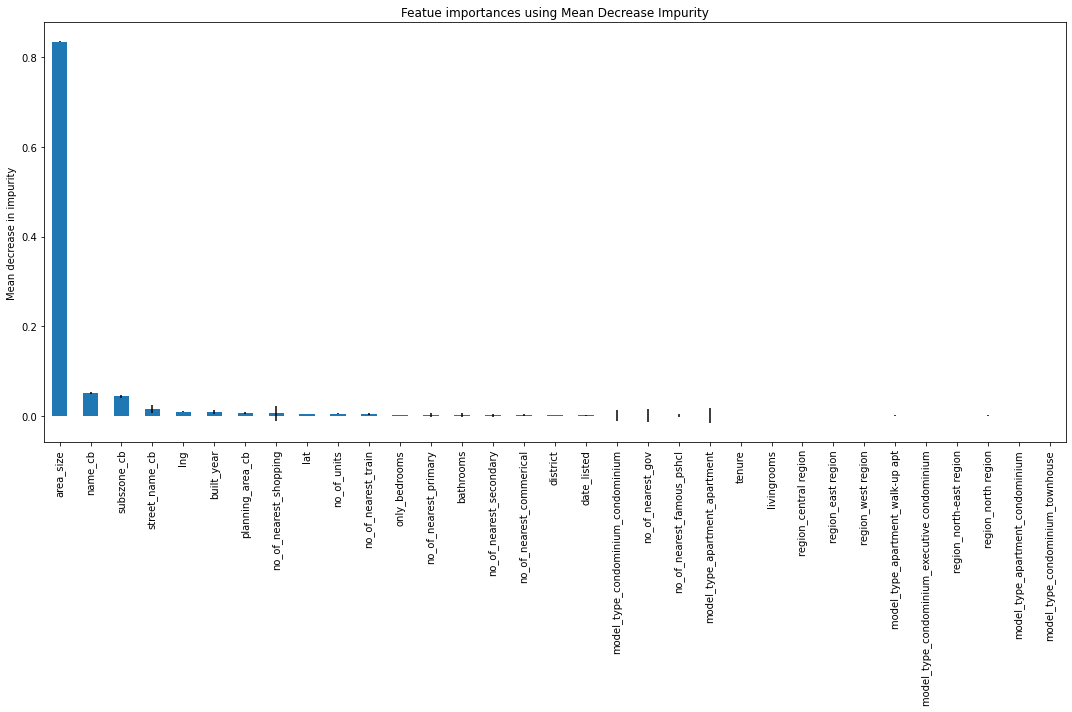

In [ ]:
# MDI distribution

def draw_MDI_dist(rf, X):
    plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')


    importances = rf.feature_importances_
    sorted_MDI_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(15,10))

    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    sorted_MDI_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
    ax.set_title("Featue importances using Mean Decrease Impurity")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
    return sorted_MDI_importances

MDI_importances = draw_MDI_dist(rf1, x_train_norm)


#### Drop some less important features

customize the number of dropping

In [ ]:
drop_no = 5  # customize the number
drop_feas = list(MDI_importances.nsmallest(drop_no).index)

print(drop_feas)


X_rf_drop = x_train_norm.drop(drop_feas, axis=1)
X_test_rf_drop = x_test_norm.drop(drop_feas, axis=1)


x_train, x_valid, y_train,y_valid = train_test_split(
        X_rf_drop,
        y_train_origin,
        test_size=1/4,
        # random_state=2
)


X_rf_drop.shape, X_test_rf_drop.shape, x_train.shape, x_valid.shape

['model_type_condominium_townhouse', 'model_type_apartment_condominium', 'region_north region', 'region_north-east region', 'model_type_condominium_executive condominium']


((26048, 28), (7500, 28), (19536, 28), (6512, 28))

#### Grid Search again, on less features

Uncomment the cell!

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# # ! less features, less tree!

# # 子树数量 + decision tree 深度/min smaple split
# param_test1 = {'n_estimators':range(100, 201, 20),
#                'max_depth':range(14,21,2),
#             #    'min_samples_split':range(2,4,1)
#                }
# kfold = 4
# gsearch1 = GridSearchCV(estimator = RandomForestRegressor(), 
#                        param_grid = param_test1, 
#                        scoring='neg_root_mean_squared_error', 
#                        verbose= 1,
#                        n_jobs = 6,
#                        cv=kfold)

# # CV on all data, auto solit
# gsearch1.fit(X_rf_drop, y_train_origin)
# print(f"{kfold}-CV best params:", gsearch1.best_params_, "\nCV mean rmse", -gsearch1.best_score_)

# # get best model and its has trained!
# rf2 = gsearch1.best_estimator_

# # RMSE
# # valid_predict = rf1.predict(x_valid)
# # print(f'val RMSE:{rmse_scaled(valid_predict,y_valid)}, R2:{r2_score(valid_predict,y_valid)}')
# # print(f"CV rmse:{-cross_val_score(rf1, x_train_norm, y_train_origin, cv=5, scoring='neg_root_mean_squared_error').mean()}")

# joblib.dump(rf2, f"models/rf_drop{drop_no}feat_{-round(gsearch1.best_score_,3)}.model")

# # show new MDI dist.

# MDI_importances2 = draw_MDI_dist(rf2, X_rf_drop);


# # use rf2 with less feature to predict
# # ! predict
# test_predict = rf2.predict(X_test_rf_drop)
# test_predict = test_predict*1000000
# res=pd.DataFrame(data=test_predict,columns=['Predicted'])
# res['Id'] = res.index
# res = res[['Id','Predicted']]

# # output
# res.to_csv(f'./predict/rf_drop{drop_no}feat.csv',index=False)


continue further dropping ...

## GBDT

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


### 1 load GBDT parameters from local

In [ ]:
gbdt1 = joblib.load('models/gbdt1.model')
print(gbdt1)

kfold = 3
mean_rmse = - cross_val_score(gbdt1, x_train_norm, y_train_origin, 
                             cv=kfold,
                             n_jobs=5,
                             scoring='neg_root_mean_squared_error').mean()
print(f"{kfold}-CV mean rmse:{mean_rmse}")

GradientBoostingRegressor(alpha=0.7, max_depth=10, n_estimators=900,
                          random_state=10, subsample=0.8)
3-CV mean rmse:0.7114191046554105


In [ ]:

# fit train before predict
gbdt1.fit(x_train_norm, y_train_origin)

# prediction
test_predict = gbdt1.predict(x_test_norm)
test_predict = test_predict*1000000

res=pd.DataFrame(data=test_predict,columns=['Predicted'])
res['Id'] = res.index
res = res[['Id','Predicted']]

# output
res.to_csv(f'./predict/gbdt1.csv',index=False)

### 2 Or Grid Search from scratch

Uncomment the cell!

In [ ]:
# # Grid Search
# param_test2 = {'n_estimators':range(600, 1001, 100),
#                'max_depth':range(7, 12, 2),
#                'subsample': [0.8],
#                'alpha': [.7]
#             #    'min_samples_split':range(2,5,2)
#                }
# kfold = 4
# gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(random_state=10), 
#                        param_grid = param_test2, scoring='neg_root_mean_squared_error', 
#                        cv=kfold, 
#                        n_jobs = 6, 
#                        verbose=1)

# # CV on all data, auto solit
# gsearch2.fit(x_train_norm,y_train_origin)
# print(f"{kfold}-CV best fit:", gsearch2.best_params_, "\nCV rmse", - gsearch2.best_score_)


# gbdt1 = gsearch2.best_estimator_

# # predict
# test_predict = gbdt1.predict(X_test_rf_drop)
# test_predict = test_predict*1000000
# res=pd.DataFrame(data=test_predict,columns=['Predicted'])
# res['Id'] = res.index
# res = res[['Id','Predicted']]

# # output
# res.to_csv(f'./predict/gbdt1.csv',index=False)


Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[CV] alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8 .........[CV] alpha=0.7, max_depth=7, n_estimators=700, subsample=0.8 .........

[CV] alpha=0.7, max_depth=7, n_estimators=700, subsample=0.8 .........
[CV] alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8 .........
[CV] alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8 .........
[CV] alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8, score=-0.594, total= 2.9min
[CV]  alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8, score=-0.829, total= 2.9min
[CV] alpha=0.7, max_depth=7, n_estimators=700, subsample=0.8 .........
[CV] alpha=0.7, max_depth=7, n_estimators=700, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8, score=-0.973, total= 2.9min
[CV] alpha=0.7, max_depth=7, n_estimators=800, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=7, n_estimators=600, subsample=0.8, score=-0.867, total= 2.9m

[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 14.6min


[CV]  alpha=0.7, max_depth=9, n_estimators=700, subsample=0.8, score=-0.973, total= 4.5min
[CV] alpha=0.7, max_depth=9, n_estimators=800, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=9, n_estimators=700, subsample=0.8, score=-0.545, total= 4.5min
[CV] alpha=0.7, max_depth=9, n_estimators=800, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=9, n_estimators=700, subsample=0.8, score=-0.858, total= 4.5min
[CV] alpha=0.7, max_depth=9, n_estimators=900, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=9, n_estimators=700, subsample=0.8, score=-0.971, total= 4.5min
[CV] alpha=0.7, max_depth=9, n_estimators=900, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=9, n_estimators=800, subsample=0.8, score=-0.967, total= 5.3min
[CV] alpha=0.7, max_depth=9, n_estimators=900, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=9, n_estimators=800, subsample=0.8, score=-0.550, total= 5.3min
[CV] alpha=0.7, max_depth=9, n_estimators=900, subsample=0.8 .........
[CV]  alpha=0.7, max_depth=9

[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed: 38.4min finished


4-CV best fit: {'alpha': 0.7, 'max_depth': 7, 'n_estimators': 900, 'subsample': 0.8} 
CV rmse 0.8137145032208839
一次切分val RMSE:0.21310989953328213, R2:0.9974715709361928


## XGBoost

In [ ]:
from xgboost.sklearn import XGBRegressor

### 1 load XGBoost parameters from local

In [ ]:
xgb1 = joblib.load('models/xgb_date.model') # this model drop feature, date
print(xgb1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.03, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=7, min_child_weight=6, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [ ]:
# fit train before predict
x_xgb_train = x_train_norm.drop(["date_listed"], axis=1)
xgb1.fit(x_xgb_train, y_train_origin)

# predict
x_xgb_test = x_test_norm.drop(["date_listed"], axis=1) # drop the feature first

test_predict = xgb1.predict(x_xgb_test)
test_predict = test_predict*1000000
res=pd.DataFrame(data=test_predict,columns=['Predicted'])
res['Id'] = res.index
res = res[['Id','Predicted']]


file = 'xgb_drop_date'
res.to_csv(f'./predict/{file}.csv',index=False)

### 2 Or Train(grid search) from scratch

Uncomment the cell!

In [ ]:
# # import xgboost as xgb
# # xgb.config_context(verbose=0)
# from sklearn.model_selection import GridSearchCV

# xgb1 = XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'], # 似乎没有R^2可以选
#               'learning_rate': [0.15, 0.2], #so called `eta` value, 默认：0.3。别名：learning_rate。
#             # 用于防止过拟合。在每个提升步骤之后，eta缩小特征权重以使提升过程更加健壮。
#               'max_depth': [5, 6, 7], # 过拟合
#               'min_child_weight': [4, 6], # 决定最小叶子节点样本权重和。用于避免过拟合。当它的值较大时，
#               'subsample': [0.5, 0.7], # 减小这个参数的值，算法会更加保守，避免过拟合, 0.5~1
#               'gamma': [0.02, 0.03], # 节点分裂所需的最小损失函数下降值。这个参数的值越大，算法越保守
#               'colsample_bytree': [0.5, 0.7], # 0.5-1
#               'n_estimators': range(500,1001,100),
#               }

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = kfold,
#                         n_jobs = 5,
#                         verbose=1,
#                         scoring='neg_root_mean_squared_error'
#                         )

# xgb_grid.fit(x_train_norm,y_train_origin)

# xgb1 = xgb_grid.best_estimator_

# print('squared error', -xgb_grid.best_score_) 
# print(xgb_grid.best_params_)

# joblib.dump(xgb1, './models/xgb.model');

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 22.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 40.7min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 68.8min
[Parallel(n_jobs=5)]: Done 1728 out of 1728 | elapsed: 100.6min finished


-0.7234991335474642 squared error
{'colsample_bytree': 0.7, 'gamma': 0.03, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.5}


In [ ]:
# predict ....

## LightGBM

### 1 load LGB parameters from local

In [26]:
gbm = joblib.load('models/gbm.model') # this model drop feature, date
print(gbm)

LGBMRegressor(learning_rate=0.5, max_depth=12, metric='rmsle',
              objective='regression', verbose=0)


In [27]:
# fit train before predict
x_lgb_train = x_train_norm.drop(["date_listed"], axis=1)
gbm.fit(x_lgb_train, y_train_origin)

# predict
x_lgb_test = x_test_norm.drop(["date_listed"], axis=1) # drop the feature first

test_predict = gbm.predict(x_lgb_test)
test_predict = test_predict*1000000
res=pd.DataFrame(data=test_predict,columns=['Predicted'])
res['Id'] = res.index
res = res[['Id','Predicted']]


file = 'lgb_drop_date'
res.to_csv(f'./predict/{file}.csv',index=False)

### 2 Or Train(grid search) from scratch

Uncomment the cell!

In [25]:
# import lightgbm as lgb
# params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['regression'],
#     'metric': ['rmsle'],
#     'max_depth': range(8,20,4), 
#     'learning_rate': [0.1,0.5],
#     'verbose': [0]}


# gbm = lgb.LGBMRegressor()

# kfold=3
# gsearch = GridSearchCV(gbm, param_grid=params, cv=kfold)
# gsearch.fit(x_train_norm, y_train_origin)

# gbm =  gsearch.best_estimator_

# print(gsearch.best_estimator_)
# print(gsearch.best_score_)

# joblib.dump(gbm, './models/gbm.model')


LGBMRegressor(learning_rate=0.5, max_depth=12, metric='rmsle',
              objective='regression', verbose=0)
0.970236922232257


['/content/model/gbm.model']